In [9]:
import time
import re
import os
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import requests

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Input, Reshape, BatchNormalization, Dense, Dropout,       # General
    Embedding, LSTM, Dense, GRU,                              # RNN
    Conv2D, Conv2DTranspose, LeakyReLU, MaxPool2D, Flatten    # CNN
)
from tensorflow.keras.activations import elu, relu, softmax, sigmoid

print(tf.__version__)

2.2.0


In [2]:
# Read the Divina Commedia
url = "https://raw.githubusercontent.com/DanieleVeri/deep_comedy/feature/GANs/divina_commedia.txt"
#url = "https://raw.githubusercontent.com/DanieleVeri/deep_comedy/master/divina_commedia_sillabe.txt"
response = requests.get(url)

divina_commedia = response.text

# Replace rare characters
divina_commedia = divina_commedia.replace("ä", "a")
divina_commedia = divina_commedia.replace("é", "è")
divina_commedia = divina_commedia.replace("ë", "è")
divina_commedia = divina_commedia.replace("Ë", "E")
divina_commedia = divina_commedia.replace("ï", "i")
divina_commedia = divina_commedia.replace("Ï", "I")
divina_commedia = divina_commedia.replace("ó", "ò")
divina_commedia = divina_commedia.replace("ö", "o")
divina_commedia = divina_commedia.replace("ü", "u")
divina_commedia = divina_commedia.replace("(", "-")
divina_commedia = divina_commedia.replace(")", "-")
divina_commedia = divina_commedia.replace("[", "")
divina_commedia = divina_commedia.replace("]", "")
divina_commedia = re.sub(r'[0-9]+', '', divina_commedia)
divina_commedia = divina_commedia.replace(" \n", "\n")

unique_chars = list(set(divina_commedia))
unique_chars.sort()  # to make sure you get the same encoding at each run
char2idx = { char[1]: char[0] for char in enumerate(unique_chars) }

def numerical_encoding(text, char_dict):
    """ Text to list of chars, to np.array of numerical idx """
    chars_list = [ char for char in text ]
    chars_list = [ char_dict[char] for char in chars_list ]
    chars_list = np.array(chars_list)
    return chars_list

encoded_text = numerical_encoding(divina_commedia, char2idx)

# 2D formatted text
canti = divina_commedia.split("\n\n")

num_lines = 0
max_len = 0
for c in canti:
  lines = c.split('\n')
  num_lines += len(lines)
  for l in lines:
    if len(l) > max_len:
      max_len = len(l)

formatted = np.zeros((num_lines, max_len+2), dtype=int)

rhymes = []
num_lines = 0
for i in canti:
  lines = i.split('\n')
  for j in lines:
    rhymes.append(j.split(' ')[-1])
    encoded = numerical_encoding(j+'\n', char2idx)
    left_padding = np.ones(max_len-len(encoded)+2)
    formatted[num_lines, :] = np.concatenate((left_padding, encoded))
    num_lines += 1

# word voc
'''
for c in canti:
  lines = c.split('\n')
  for l in lines:
'''
sub = re.sub(r'[\n"\',.;:()]', ' ', divina_commedia.lower())
unique_words = list(set(sub.split(' ')))
unique_words.sort()
word2idx = { w[1]: w[0] for w in enumerate(unique_words) }

# syllabe
div_ls = set()
aa = divina_commedia.split('\n')
for x in aa:
  y = x.split(sep='-')
  for t in y:
    div_ls.add(t) 

uniq_sylla = list(div_ls)
uniq_sylla.sort()  
sylla2idx = { s[1]: s[0] for s in enumerate(uniq_sylla) }

formatted_syll = np.zeros((num_lines, 18), dtype=int)
num_lines = 0
for i in canti:
  lines = i.split('\n')
  for j in lines:
    s = j.split('-')
    yo = []
    for cc in s:
      yo.append(sylla2idx[cc])
    yo.append(0)
    left_padding = np.ones(18-len(yo))
    formatted_syll[num_lines, :] = np.concatenate((left_padding, yo))
    num_lines += 1

print(formatted.shape)
#print(word2idx)
#print(formatted_syll[0:9, :])

(14234, 52)


In [61]:
# size of vocabulary
vocab_size = len(char2idx)
normalized = (formatted - vocab_size/2)/(vocab_size / 2)

noise_dim = (52,52,1)

discriminator = Sequential()
discriminator.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[52, 52, 1]))
discriminator.add(LeakyReLU())
discriminator.add(MaxPool2D((2,2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1))

discriminator.summary()

input_noise = Input(shape=noise_dim)
input_noise = Model(inputs=input_noise, outputs=input_noise)

input_txt = Input(shape=(52,52,1))
input_txt = Model(inputs=input_txt, outputs=input_txt)

combined = tf.keras.backend.concatenate([input_noise.output, input_txt.output])

generator = Flatten()(combined)

generator = Dense(52*52*2, use_bias=False, input_shape=(52*52*2,))(generator)
generator = Dense(52*52, use_bias=False, input_shape=(52*52*2,))(generator)
generator = Reshape((52, 52, 1))(generator)
'''
generator = BatchNormalization()(generator)
generator = LeakyReLU()(generator)
generator = Reshape((13, 13, 256))(generator)
#assert generator.output_shape == (None, 13, 13, 256) # Note: None is the batch size
generator = Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(generator)
#assert generator.output_shape == (None, 13, 13, 128)
generator = BatchNormalization()(generator)
generator = LeakyReLU()(generator)
generator = Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(generator)
#assert generator.output_shape == (None, 26, 26, 64)
generator = BatchNormalization()(generator)
generator = LeakyReLU()(generator)
generator = Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(generator)
#assert generator.output_shape == (None, 52, 52, 1)
'''
generator = Model(inputs=[input_noise.input, input_txt.input], outputs=generator)
generator.summary()

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-3)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-3)

num_examples_to_generate = 16
BATCH_SIZE = 3
EPOCHS = 1000

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
@tf.function
def train_step(images):
    noise = tf.random.normal(shape=(BATCH_SIZE, 52,52,1))

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator([noise, images], training=True)
      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)
      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    for image_batch in dataset:
      train_step(image_batch)
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
      
splitted = np.split(normalized[0:normalized.shape[0]-normalized.shape[0]%52], normalized.shape[0] // 52)
splitted = np.array(splitted).reshape(len(splitted), 52, 52, 1)
print("tot txt", splitted.shape)
train_dataset = tf.data.Dataset.from_tensor_slices(splitted).shuffle(60000).batch(BATCH_SIZE)
train(train_dataset, EPOCHS)


Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_70 (Conv2D)           (None, 26, 26, 64)        1664      
_________________________________________________________________
leaky_re_lu_92 (LeakyReLU)   (None, 26, 26, 64)        0         
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
dropout_70 (Dropout)         (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_93 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_71 (Dropout)         (None, 7, 7, 128)       

['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']




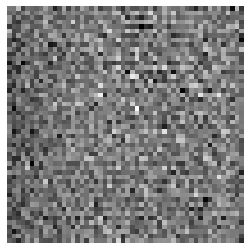

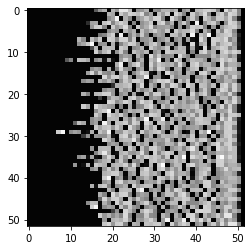

In [67]:
idx2char = { v: k for k, v in char2idx.items() } 

def generate_and_save_images(model):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  noise = tf.random.normal(shape=(1,52,52,1))
  predictions = model([noise, np.reshape(normalized[0:52,:], (1,52,52,1))], training=False)

  fig = plt.figure(figsize=(20,20))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
      
      res = []
      for a in range(52):
        line = []
        for b in range(52):
          '''
          discretized = math.floor(predictions[i, a, b, 0] * vocab_size/2 + vocab_size/2)
          line.append(idx2char[discretized])
          '''
        res.append(''.join(line))
      print("=============")
      print(res)
      print("=============\n\n")

  plt.show()

generate_and_save_images(generator)

plt.imshow(normalized[0:52,:], cmap='gray')
plt.show()